In [17]:
# Read in the data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

bbc_data = pd.read_csv('bbc_data.csv')

bbc_data.head()

,data,labels
0,Musicians to tackle US red tape Musicians gro...,entertainment
1,"U2s desire to be number one U2, who have won ...",entertainment
2,Rocker Doherty in on-stage fight Rock singer ...,entertainment
3,Snicket tops US box office chart The film ada...,entertainment
4,"Oceans Twelve raids box office Oceans Twelve,...",entertainment


In [18]:
# Print the number of documents in each label
print(bbc_data['labels'].value_counts())

print(bbc_data[bbc_data['labels'].isnull()])

labels
sport            511
business         510
politics         417
tech             401
entertainment    386
Name: count, dtype: int64
Empty DataFrame
Columns: [data, labels]
Index: []


In [ ]:
# EDA: Get average number of words in each document per label, as well as mins and maxes.
# Create scatter plots for these averages.

# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [19]:
# Train test split and preprocess the data

from sklearn.model_selection import train_test_split
import gensim
from gensim import corpora, models, similarities, matutils
from gensim import utils

X = bbc_data['data'].apply(gensim.utils.simple_preprocess)
y = bbc_data['labels']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [21]:
# Feature Engineering: Word2Vec model (similar to TF-IDF, but makes more sense for NLP tasks)

from gensim.models import Word2Vec

w2v_model = Word2Vec(X_train, vector_size=300, window=15, min_count=2, epochs=10) # Took 16.6 seconds to train

In [24]:
# Feature Engineering: Vectorize data

from sklearn.feature_extraction.text import TfidfVectorizer

# Function created to vectorize each document/data point
def vectorize_data(corpus, model):
    result = []
    for sentence in corpus:
        counter = 0
        bucket = np.zeros(model.vector_size)
        for word in sentence:
            if word in model.wv:
                counter += 1
                bucket += model.wv[word]
            else:
                pass
        bucket = bucket / counter
        result.append(bucket)
    return result

# Vectorize
words = set(w2v_model.wv.index_to_key)
X_train_vec = vectorize_data(X_train, w2v_model)
X_test_vec = vectorize_data(X_test, w2v_model)

In [25]:
# Test the vectorized data on a simple random forest model

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf = RandomForestClassifier()
rf.fit(X_train_vec, y_train)

# Took 4.1 seconds to train

RandomForestClassifier()

In [28]:
# Cross Validation for Random Forest Model
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(rf, X_train_vec, y_train, cv=5)
print('Validation score for each label:', cv_scores) # Cell took 11.6 seconds to run

Validation score for each label [0.9494382  0.95505618 0.9494382  0.9494382  0.96348315]


In [29]:
from sklearn.model_selection import cross_validate

cv_result = pd.DataFrame(
        cross_validate(rf, X_train_vec,y_train,scoring=['accuracy'], return_train_score=True, verbose=0, n_jobs=-1, cv=6)
    ).rename(columns={'test_accuracy':'val_accuracy'}).iloc[:,2:]

# score
val_score = cv_result['val_accuracy'].mean()
train_score = cv_result['train_accuracy'].mean() 
test_score = accuracy_score(y_true=y_test,y_pred=rf.predict(X_test_vec))

print('Averages for all labels combined:')
print('Training Score: ',train_score)
print('Validation Score: ',val_score) 
print('Test Score: ',test_score) # Cell took 25.2 seconds to run

Averages for all labels combined:
Training Score:  1.0
Validation Score:  0.9494475536142203
Test Score:  0.9662921348314607


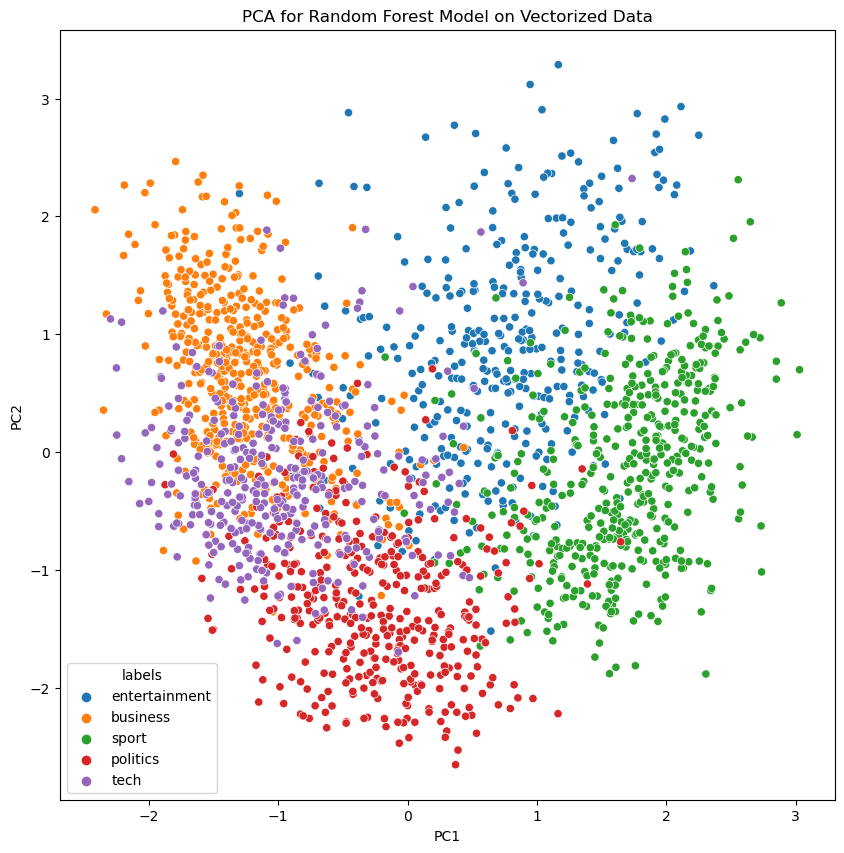

In [33]:
# PCA/Visualize Random Forest model on the Vectorized Data
from sklearn.decomposition import PCA

pca_rf = PCA(n_components=2)
pca_rf_df = pd.DataFrame(pca_rf.fit_transform(vectorize_data(X, w2v_model)), columns=['PC1','PC2'])
pca_rf_df['labels'] = bbc_data['labels'].copy()

plt.figure(figsize=(10,10))
sns.scatterplot(data=pca_rf_df, x='PC1', y='PC2', hue='labels')
plt.title('PCA for Random Forest Model on Vectorized Data')
plt.show()
# Cell took 5.2 seconds to run

In [34]:
# Now let's try Word2Vec using Google's pre-trained model

import gensim.downloader as api

list(api.info()['models'].keys())

['fasttext-wiki-news-subwords-300',
 'conceptnet-numberbatch-17-06-300',
 'word2vec-ruscorpora-300',
 'word2vec-google-news-300',
 'glove-wiki-gigaword-50',
 'glove-wiki-gigaword-100',
 'glove-wiki-gigaword-200',
 'glove-wiki-gigaword-300',
 'glove-twitter-25',
 'glove-twitter-50',
 'glove-twitter-100',
 'glove-twitter-200',
 '__testing_word2vec-matrix-synopsis']

In [36]:
from gensim.models import KeyedVectors
'''
# Uncomment the line below to download Google's pre-trained model
wv = api.load('word2vec-google-news-300')

# Save pretrained vector (uncomment line below too)
wv.save('vectors.kv')

# !!! THE COMMENTED PORTION ABOVE TOOK 20 minutes to run/download the pre-trained model
# It is stored in this REPO so no need to download again! Line below should load Google's model without downloading anything.
# Also, the pre-trained vectors model is 1.7 GB in size.
'''

wv = KeyedVectors.load('vectors.kv', mmap='r')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [37]:
# Function to vectorize data with Google's pre-trained model

def google_data_vectorizer(corpus):
    result = []
    for sentence in corpus:
        counter = 0
        bucket = np.zeros(wv.vector_size)
        for word in sentence:
            if word in wv:
                counter += 1
                bucket += wv[word]
            else:
                pass
        bucket = bucket / counter
        result.append(bucket)
    return result

# Vectorize the data
words = set(wv.index_to_key) # Words in the pre-trained model
X_train_google = google_data_vectorizer(X_train)
X_test_google = google_data_vectorizer(X_test)

# Cell took 21.0 seconds to run

In [38]:
# Random Forest Model with Google's modeled data
rf_google = RandomForestClassifier()
rf_google.fit(X_train_google, y_train)

# Cell took 5.4 seconds to run

RandomForestClassifier()

In [43]:
# Cross validation for RF of google's modeled data

cv_scores = cross_val_score(rf, X_train_vec, y_train, cv=5)
print('Validation score for each label:', cv_scores)

cv_result = pd.DataFrame(
        cross_validate(rf_google, X_train_google,y_train,scoring=['accuracy'], return_train_score=True, verbose=0, n_jobs=-1, cv=6)
    ).rename(columns={'test_accuracy':'val_accuracy'}).iloc[:,2:]

# Cell took 20.5 seconds to run

Validation score for each label: [0.94662921 0.95224719 0.94662921 0.94662921 0.95786517]


In [42]:
# score
val_score = cv_result['val_accuracy'].mean()
train_score = cv_result['train_accuracy'].mean() 
test_score = accuracy_score(y_true=y_test,y_pred=rf.predict(X_test_vec))

print('Averages for all labels combined:')
print('Training Score: ',train_score)
print('Validation Score: ',val_score) 
print('Test Score: ',test_score)

Averages for all labels combined:
Training Score:  1.0
Validation Score:  0.9522552855886189
Test Score:  0.9662921348314607


Text(0.5, 1.0, 'PCA for Random Forest Model on Google Modeled Data')

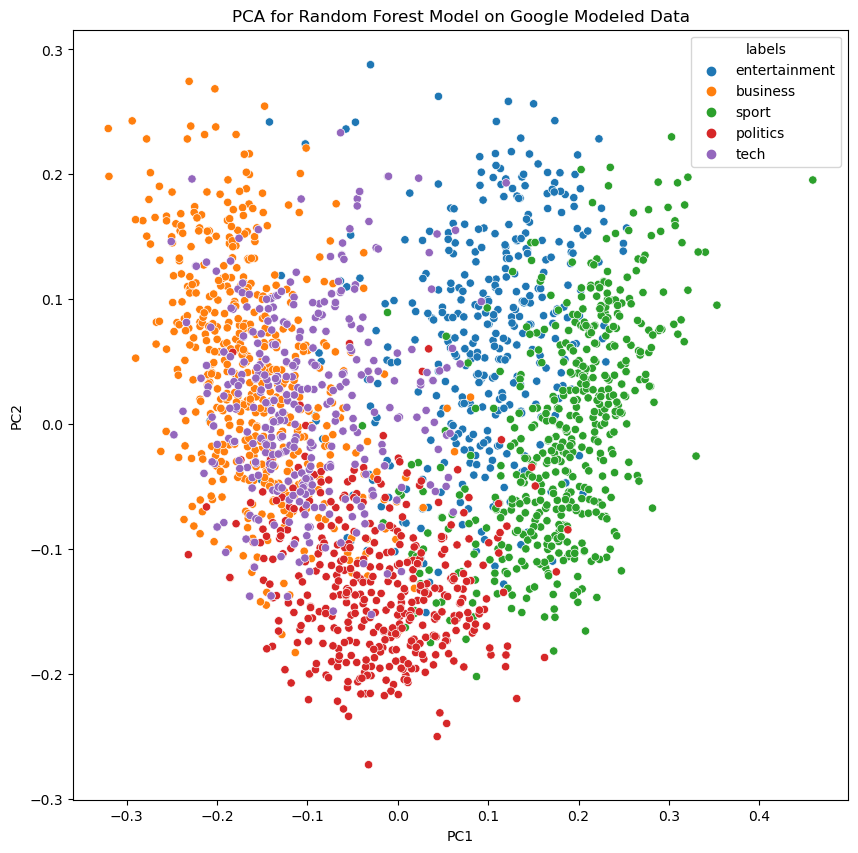

In [44]:
# PCA of Google's modeled data with Random Forest
pca_rf_google = PCA(n_components=2)
pca_rf_google_df = pd.DataFrame(pca_rf_google.fit_transform(google_data_vectorizer(X)), columns=['PC1','PC2'])
pca_rf_google_df['labels'] = bbc_data['labels'].copy()

plt.figure(figsize=(10,10))
sns.scatterplot(data=pca_rf_google_df, x='PC1', y='PC2', hue='labels')
plt.title('PCA for Random Forest Model on Google Modeled Data')

Of the 5 labels, 3 seem very similar to each other in nature on the PCA plot, while the other two are also similar to one another. The labels of "Politics", "Tech", and "Business" all behave similarly to each other. The other two labels, "Sports" and "Entertainment", separate from the other labels, differing in nature. The similarities in label's PCA plots are because of the similarities in the topics/labels. Documents discussing sports and entertainment, for example, are shorter on average and use less nouns and difficult, label specific vocabulary. On the other hand, the labels of politcs, tech, and business all tend to be longer in length, and use a higher level vocabulary that stands out as more label-specific.